# 0. Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_ebay_raw = pd.read_excel("data/ebayAuctions.xlsx", sheet_name="eBay auctions")

In [3]:
df_ebay_raw.head(3)

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [4]:
df_ebay_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [5]:
df_ebay_raw.describe()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,36.449087,12.926268,0.540568
std,5973.011033,2.052906,89.493858,38.856149,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.907500,1.230000,0.000000
50%,1853.000000,7.000000,9.995000,4.500000,1.000000
75%,3380.000000,7.000000,28.000000,9.990000,1.000000
max,37727.000000,10.000000,999.000000,999.000000,1.000000


# 1. Preprocessing
## 1.1 Create dummy variables for Category, Currency, Enday and Duration

In [6]:
df_category_dummy = df_ebay_raw['Category'].str.get_dummies(sep='/')
df_currency_dummy = df_ebay_raw['Currency'].str.get_dummies()
df_endDay_dummy = df_ebay_raw['endDay'].str.get_dummies()
df_duration_dummy = pd.get_dummies(df_ebay_raw['Duration'], prefix="Duration")

In [7]:
# drop origin categorical columns
df_ebay = df_ebay_raw.drop(columns=["Category", "Currency", "endDay", "Duration"])

In [8]:
# concatenate back the dummy variables
df_ebay = pd.concat([df_category_dummy, df_currency_dummy, df_endDay_dummy, df_duration_dummy, df_ebay], axis=1)

## 1.2 Scaling seller Rating variable

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_ebay[['sellerRating']] = scaler.fit_transform(df_ebay[['sellerRating']])

In [10]:
df_ebay.head(3)

,Accessories,Antique,Art,Automotive,Beauty,Books,Business,Clothing,Coins,Collectibles,...,Wed,Duration_1,Duration_3,Duration_5,Duration_7,Duration_10,sellerRating,ClosePrice,OpenPrice,Competitive?
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.086119,0.01,0.01,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.086119,0.01,0.01,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.086119,0.01,0.01,0


# 2. Split Data 6:4

In [11]:
from sklearn.model_selection import train_test_split
X = df_ebay.drop(columns=["Competitive?"])
y = df_ebay["Competitive?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# 3. Fit a classification tree

In [12]:
# Helper function to generate rules
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [13]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(min_samples_leaf = 50)
clf = clf.fit(X_train, y_train)

In [14]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       359
           1       0.88      0.79      0.83       430

    accuracy                           0.83       789
   macro avg       0.83      0.83      0.83       789
weighted avg       0.83      0.83      0.83       789



In [15]:
# generate rules
rules = get_rules(clf, list(X_train.columns), [0, 1])
with open("rules1.txt", "w") as fp:
    for r in rules:
        fp.write(r+"\n")

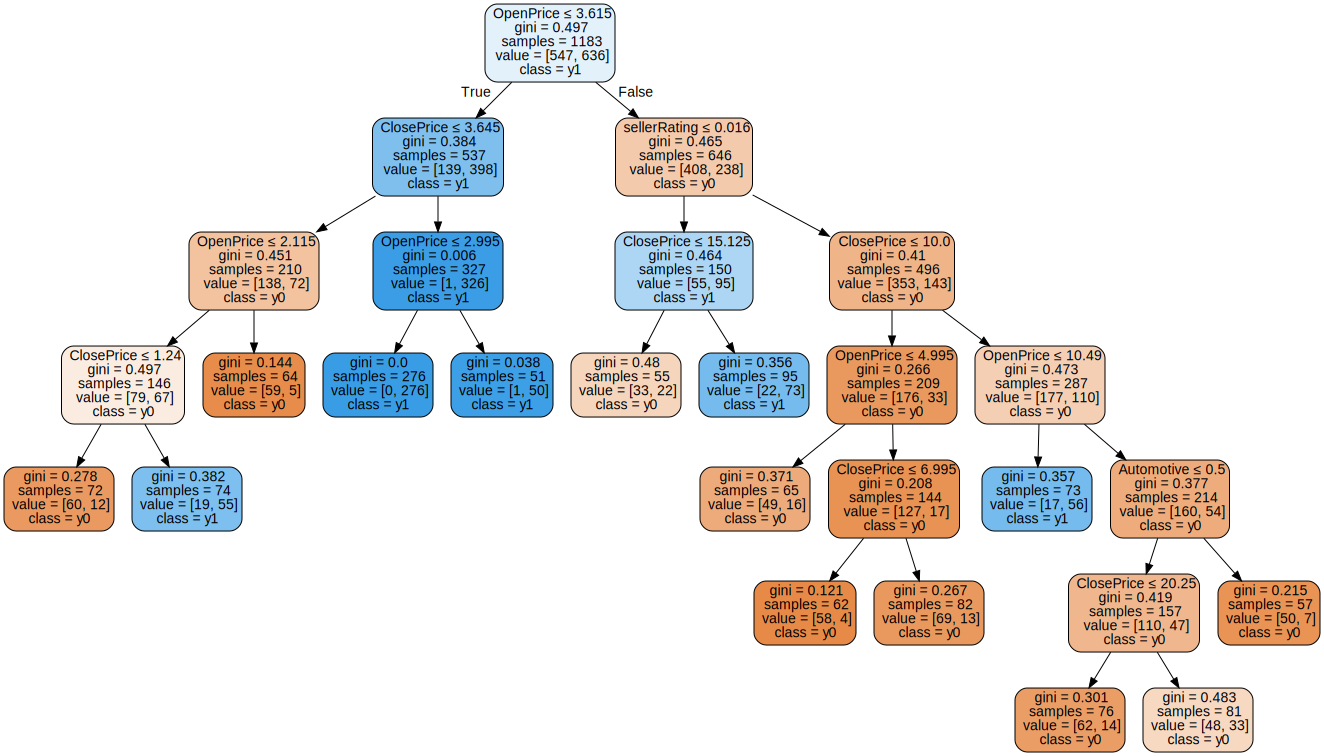

In [16]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=True,
                      filled=True, rounded=True,  
                      special_characters=True) 
graph = graphviz.Source(dot_data)
graph.render(filename='tree1.dot')
graph

It's not practical, as we do not know closeprice at the beginning of the auction.

# 4. Fit a new model without closing infos

In [17]:
# It's the same, just exclude endDay and closing price
df_ebay_new = df_ebay_raw.drop(columns=["Category", "Currency", "endDay", "Duration", "ClosePrice"])
df_ebay_new = pd.concat([df_category_dummy, df_currency_dummy, df_duration_dummy, df_ebay_new], axis=1)

df_ebay_new[['sellerRating']] = scaler.fit_transform(df_ebay_new[['sellerRating']])

In [18]:
X = df_ebay_new.drop(columns=["Competitive?"])
y = df_ebay_new["Competitive?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = tree.DecisionTreeClassifier(min_samples_leaf = 50)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       359
           1       0.73      0.77      0.75       430

    accuracy                           0.72       789
   macro avg       0.72      0.72      0.72       789
weighted avg       0.72      0.72      0.72       789



In [19]:
# generate rules
rules = get_rules(clf, list(X_train.columns), [0, 1])
with open("rules2.txt", "w") as fp:
    for r in rules:
        fp.write(r+"\n")

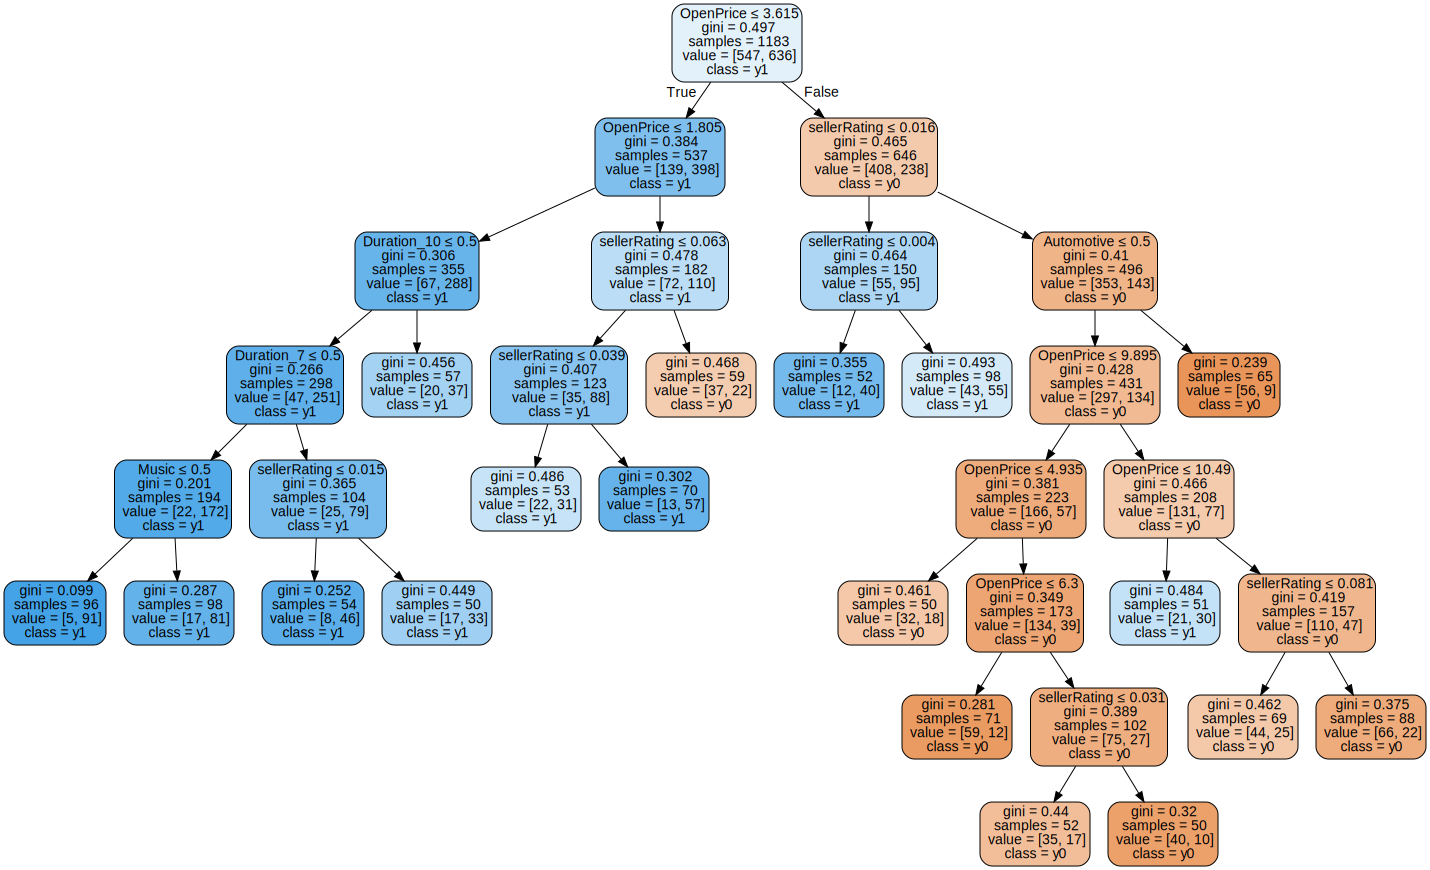

In [20]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns,  
                      class_names=True,
                      filled=True, rounded=True,  
                      special_characters=True) 
graph = graphviz.Source(dot_data)
graph.render(filename='tree2.dot')
graph

In [21]:
df_two_predictors = df_ebay_raw[["sellerRating", "OpenPrice", "Competitive?"]]
df_two_predictors[['sellerRating']] = scaler.transform(df_two_predictors[['sellerRating']])
# df_two_predictors['OpenPrice'] = np.log10(df_two_predictors['OpenPrice'])


/var/folders/m3/4yh806w92fdgcn0bk16ql7nw0000gn/T/ipykernel_80413/190103638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_two_predictors[['sellerRating']] = scaler.transform(df_two_predictors[['sellerRating']])


<AxesSubplot:xlabel='sellerRating', ylabel='OpenPrice'>

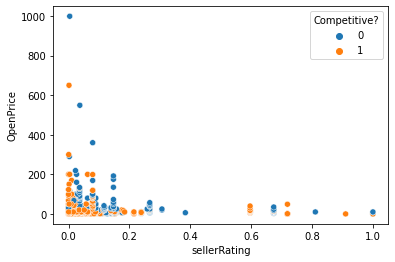

In [22]:
sns.scatterplot(x="sellerRating", y="OpenPrice", hue="Competitive?", data=df_two_predictors)

(0.0, 15.0)

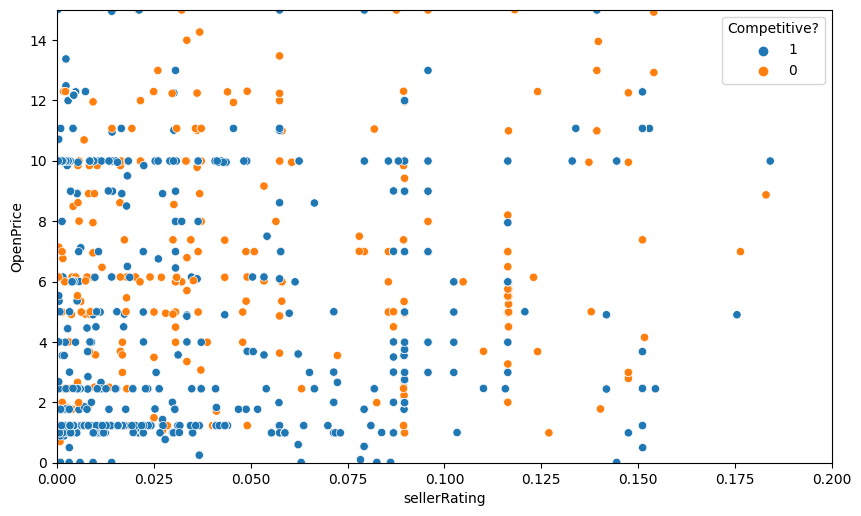

In [23]:
fig, scatter = plt.subplots(figsize = (10,6), dpi = 100)
hue_order = ['Third', 'Second', 'First']
sns.scatterplot(x="sellerRating", y="OpenPrice", hue="Competitive?", hue_order=[1, 0], data=df_two_predictors)
scatter.set_xlim(left=0, right=0.2)
scatter.set_ylim(bottom=0, top=15)